In [5]:
!pip install langchain langchain-openai
!pip install langgraph

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [7]:

from langgraph.graph import StateGraph, END
from typing import TypedDict, List
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI

In [8]:
import os
import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key:  ········


In [9]:
from langchain_core.prompts import PromptTemplate

In [12]:
from langchain_openai import ChatOpenAI
# Initialize the ChatOpenAI model
llm = ChatOpenAI(
    model_name="gpt-4o",  # Specify the model (e.g., gpt-4, gpt-3.5-turbo)
    temperature=0.7,      # Controls randomness (0 to 1)
    max_tokens=512        # Maximum tokens in the response
)

In [15]:
# State
class State(TypedDict):
	input: str
	decision: str
	output: str

In [76]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Schema for strctured output to use as routing logic
class Route(BaseModel):
	step: Literal["finance", "portfolio ", "market", "goal", "news", "tax"] = Field(
		None, description="The next step in the routing prcess"
	)

# Agument the LLM with schema for structured output

router = llm.with_structured_output(Route)

In [77]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.messages import SystemMessage, HumanMessage
# Nodes
def call_finance_qa_agent(state: State):
	""" Finance Q&A Agent """

	print(" Finance Q&A Agent: Handles general financial education queries ")
	result = llm.invoke(state["input"])
	return {"output": result.content}

def call_portfolio_analysis_agent(state: State):
	""" Portfolio Analysis Agent """

	print(" Reviews and analyzes user portfolios ")
	result = llm.invoke(state["input"])
	return {"output": result.content}

def call_market_analysis_agent(state: State):
	""" Market Analysis Agent"""

	print(" Provides real-time market insights ")
	result = llm.invoke(state["input"])
	return {"output": result.content}

def call_goal_planning_agent(state: State):
	""" Goal Planning Agent"""

	print(" Assists with financial goal setting and planning ")
	result = llm.invoke(state["input"])
	return {"output": result.content}

def call_news_synthesizer_agent(state: State):
	""" News Synthesizer Agent"""

	print(" Summarizes and contextualizes financial news ")
	result = llm.invoke(state["input"])
	return {"output": result.content}

def call_tax_education_agent(state: State):
	""" Tax Education Agent"""

	print(" Explains tax concepts and account types ")
	result = llm.invoke(state["input"])
	return {"output": result.content}


def finapp_router(state: State):
  """Route the input to the appropriate node """

  # Run the agumented LLM with strctured output to serve as routing logic
  decision = router.invoke(
		[
			SystemMessage(
				content="Route the input to finance, portfolio, market, goal, news or tax based on user request"
			),
			HumanMessage(content=state["input"]),

		]
	)
  print(f"decision: {decision.step}")  
  return {"decision": decision.step}


# Conditional edge function to route the appropriate node
def route_decision(state: State):
	decision_str = state["decision"].rstrip()
	decision_str = decision_str.lower()
	print(decision_str)
	if decision_str is None:
		return "call_finance_qa_agent"
	

	if decision_str == 'finance':
		return "call_finance_qa_agent"
	elif decision_str == 'portfolio':
		return "call_portfolio_analysis_agent"
	elif decision_str == "market":
		return "call_market_analysis_agent"
	elif decision_str == "goal":
		return "call_goal_planning_agent"
	elif decision_str == "news":
		return "call_news_synthesizer_agent"
	elif decision_str == "tax":
		return "call_tax_education_agent"


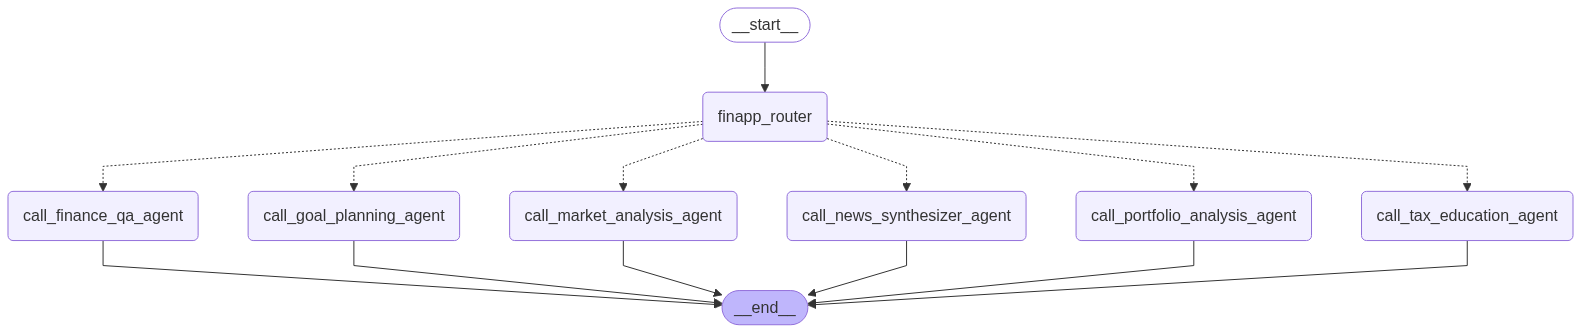

In [78]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("call_finance_qa_agent", call_finance_qa_agent)
router_builder.add_node("call_portfolio_analysis_agent", call_portfolio_analysis_agent)
router_builder.add_node("call_market_analysis_agent", call_market_analysis_agent)
router_builder.add_node("call_goal_planning_agent", call_goal_planning_agent)
router_builder.add_node("call_news_synthesizer_agent", call_news_synthesizer_agent)
router_builder.add_node("call_tax_education_agent", call_tax_education_agent)

router_builder.add_node("finapp_router", finapp_router)

# Add edges to connect nodes
router_builder.add_edge(START, "finapp_router")
router_builder.add_conditional_edges(
    "finapp_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "call_finance_qa_agent": "call_finance_qa_agent",
        "call_portfolio_analysis_agent": "call_portfolio_analysis_agent",
        "call_market_analysis_agent": "call_market_analysis_agent",
        "call_goal_planning_agent": "call_goal_planning_agent",
        "call_news_synthesizer_agent": "call_news_synthesizer_agent",
        "call_tax_education_agent": "call_tax_education_agent",
    },
)

router_builder.add_edge("call_finance_qa_agent", END)
router_builder.add_edge("call_portfolio_analysis_agent", END)
router_builder.add_edge("call_market_analysis_agent", END)
router_builder.add_edge("call_goal_planning_agent", END)
router_builder.add_edge("call_news_synthesizer_agent", END)
router_builder.add_edge("call_tax_education_agent", END)

# compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [79]:
state = router_workflow.invoke({"input": "what is portfolio?"})
print(state["output"])

decision: portfolio 
portfolio
 Reviews and analyzes user portfolios 
A portfolio is a collection of financial investments like stocks, bonds, commodities, cash, and other assets held by an individual or institution. It can also refer to a range of investments held by an individual or organization. Here are a few different contexts in which the term "portfolio" is used:

1. **Investment Portfolio**: This is the most common usage, referring to a collection of financial assets such as stocks, bonds, mutual funds, exchange-traded funds (ETFs), and other securities. An investment portfolio is designed to achieve specific financial goals and manage risk through diversification.

2. **Project Portfolio**: In project management, a portfolio refers to a collection of projects or programs that are managed and coordinated to achieve strategic business objectives. This involves prioritizing and selecting projects to ensure they align with organizational goals.

3. **Career Portfolio**: This is us

In [80]:
state = router_workflow.invoke({"input": "what is finance?"})
print(state["output"])

decision: finance
finance
 Finance Q&A Agent: Handles general financial education queries 
Finance is a broad field concerned with the management, creation, and study of money, investments, and other financial instruments. It encompasses various activities, such as investing, borrowing, lending, budgeting, saving, and forecasting. The primary goal of finance is to manage an individual's or organization's financial resources to maximize wealth and achieve financial objectives.

Finance is typically divided into three main subcategories:

1. **Personal Finance:** This involves managing an individual's or family's financial activities, such as budgeting, saving, investing, insurance, mortgage planning, and retirement planning. The focus is on meeting personal financial goals, such as purchasing a home, funding education, or ensuring a comfortable retirement.

2. **Corporate Finance:** This area of finance deals with the financial activities related to running a corporation. It involves ma

In [81]:
state = router_workflow.invoke({"input": "what is goal planning?"})
print(state["output"])

decision: goal
goal
 Assists with financial goal setting and planning 
Goal planning is the process of identifying specific objectives you want to achieve and outlining the steps necessary to reach those objectives. It involves setting clear, actionable, and measurable goals, typically within a certain timeframe, and then developing a plan to attain them. Here are some key components of effective goal planning:

1. **Clarity**: Clearly define what you want to achieve. The more specific the goal, the easier it is to plan for and accomplish.

2. **Measurability**: Establish criteria for measuring progress and success. This helps in tracking your progress and staying motivated.

3. **Achievability**: Set realistic goals that are attainable given your current resources and constraints.

4. **Relevance**: Ensure that your goals align with your broader objectives, values, and long-term aspirations.

5. **Time-bound**: Set a deadline for achieving your goals to create a sense of urgency and h

In [82]:
state = router_workflow.invoke({"input": "what is market analysis?"})
print(state["output"])

decision: market
market
 Provides real-time market insights 
Market analysis is the process of examining and evaluating the dynamics of a market within a specific industry. It involves understanding various factors that influence the market, such as size, growth rate, trends, competitive landscape, customer needs, and overall economic conditions. Conducting a market analysis helps businesses and investors make informed decisions by providing insights into the market environment.

Key components of market analysis include:

1. **Market Size and Growth**: Estimating the size of the market in terms of revenue or volume and understanding its growth trajectory over time.

2. **Market Trends**: Identifying current and emerging trends that could affect the market, such as technological advancements, changes in consumer behavior, or regulatory shifts.

3. **Target Market**: Defining and understanding the specific segment of the market that a business aims to serve, including demographic, geogr

In [83]:
state = router_workflow.invoke({"input": "what is the news?"})
print(state["output"])

decision: news
news
 Summarizes and contextualizes financial news 
Could you please specify which type of news you're interested in? For example, are you looking for updates on world events, politics, technology, entertainment, or sports?


In [84]:
state = router_workflow.invoke({"input": "Can you provide tax education?"})
print(state["output"])

decision: tax
tax
 Explains tax concepts and account types 
Yes, I can certainly help with general tax education. However, please keep in mind that I’m not a tax professional, and tax laws can vary significantly by country, state, and locality. For specific advice, it’s always best to consult with a qualified tax advisor or accountant. Here are some basic concepts and information that might be helpful:

### Basic Tax Concepts:

1. **Types of Taxes:**
   - **Income Tax:** Tax on individual or business income.
   - **Sales Tax:** Tax on sold goods and services.
   - **Property Tax:** Tax based on property value, often levied on real estate.
   - **Estate Tax:** Tax on the transfer of an estate after death.
   - **Excise Tax:** Indirect tax on specific goods, like alcohol or gasoline.

2. **Tax Entities:**
   - **Individual:** Personal tax returns filed usually annually.
   - **Corporations:** Companies file taxes separately from their owners.
   - **Non-Profits:** Organizations often hav